In [1]:
import pandas as pd

In [2]:
pr_comments_df = pd.read_parquet("hf://datasets/hao-li/AIDev/pr_comments.parquet")
pr_review_comments_df = pd.read_parquet("hf://datasets/hao-li/AIDev/pr_review_comments.parquet")
pr_reviews_df = pd.read_parquet("hf://datasets/hao-li/AIDev/pr_reviews.parquet")

C:\Users\gnand\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
totalPRCount = float(pr_reviews_df['pr_id'].nunique())
totalPRCount

8140.0

In [4]:
all_PR_review_states = pr_reviews_df['state'].unique()
print(all_PR_review_states)

['COMMENTED' 'APPROVED' 'CHANGES_REQUESTED' 'DISMISSED']


In [5]:
commented_state_df = pr_reviews_df.query('state == "COMMENTED"')
commented_state_count = float(commented_state_df['pr_id'].nunique())
commented_state_count

5810.0

In [6]:
code_issue_keywords = ["incorrect", "error", "syntax", "bug", "fix", "inconsisten", "naming", "convention", "style", "efficient", "optimize", "optimization"]

def keywords_matched(string) :
    if string is None:
        return False

    string = str(string)
    if any(sub in string for sub in code_issue_keywords) :
        return True

    return False

In [7]:
pr_review_comments_with_comment_state = pr_review_comments_df[pr_review_comments_df['pull_request_review_id'].isin(commented_state_df['id'])]
pr_reviews_comments_with_comment_issues = pr_review_comments_with_comment_state[pr_review_comments_with_comment_state['body'].apply(keywords_matched)]
commented_state_with_issues_df = commented_state_df[commented_state_df['id'].isin(pr_reviews_comments_with_comment_issues['pull_request_review_id'])]
commented_state_with_issues_df2 = commented_state_df[commented_state_df['body'].apply(keywords_matched)]
commented_state_with_issues_df = pd.concat([commented_state_with_issues_df, commented_state_with_issues_df2])
commented_state_with_issues_count = float(commented_state_with_issues_df['pr_id'].nunique())
commented_state_with_issues_count

2796.0

In [8]:
changes_requested_df = pr_reviews_df.query('state == "CHANGES_REQUESTED"')
changesRequestedPRCount = float(changes_requested_df['pr_id'].nunique())
changesRequestedPRCount

988.0

In [9]:
all_possible_issue_PRs_df = pd.concat([changes_requested_df, commented_state_df])
all_possible_issue_PRs_count = float(all_possible_issue_PRs_df['pr_id'].nunique())
all_possible_issue_PRs_count

6108.0

In [11]:
commented_state_with_possible_issues_count =  commented_state_count - commented_state_with_issues_count

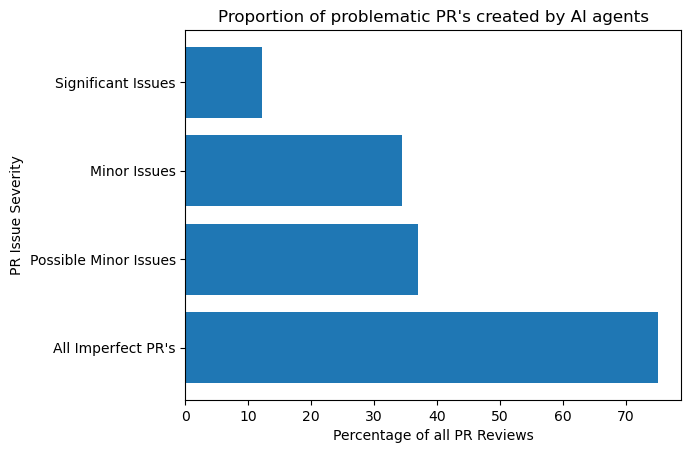

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# If running in a Jupyter Notebook, include this line to display plots inline
%matplotlib inline 

# Sample data
categories = np.array(["All Imperfect PR's", "Possible Minor Issues", "Minor Issues", "Significant Issues"])
values = np.array([all_possible_issue_PRs_count/totalPRCount*100, 
                   commented_state_with_possible_issues_count/totalPRCount*100, 
                  commented_state_with_issues_count/totalPRCount*100, 
                    changesRequestedPRCount/totalPRCount*100])

# Create the bar chart
plt.barh(categories, values)

# Add a title and labels
plt.title("Proportion of problematic PR's created by AI agents")
plt.xlabel("Percentage of all PR Reviews")
plt.ylabel("PR Issue Severity")

# Display the chart
plt.show()

In [13]:
code_issue_keywords = ["incorrect", "error", "syntax", "bug", "fix", "inconsisten", "naming", "convention", "style", "efficient", "optimize", "optimization"]
issue_types = {"incorrect": "errors or wrong implementations", "error": "errors or wrong implementations", "syntax": "errors or wrong implementations", "issue": "errors or wrong implementations", "bug": "errors or wrong implementations", "fix": "errors or wrong implementations", "inconsisten": "code style and conventions", "naming": "code style and conventions", "convention": "code style and conventions", "style": "code style and conventions", "efficient":"code quality, code structure or efficiency", "optimize":"code quality, code structure or efficiency", "optimization":"code quality, code structure or efficiency"}
issue_counts = {"errors or wrong implementations": 0, "code style and conventions":0, "code quality, code structure or efficiency": 0}
issue_PR_id_lists = {"errors or wrong implementations": set(), "code style and conventions":set(), "code quality, code structure or efficiency": set()}

In [14]:
problematic_PR_review_comments_df = pr_review_comments_df[pr_review_comments_df['pull_request_review_id'].isin(all_possible_issue_PRs_df['id'])]

for keyword in code_issue_keywords : 
    matching_pr_review_comments = problematic_PR_review_comments_df[problematic_PR_review_comments_df['body'].str.find(keyword) != -1]
    matching_pr_reviews = all_possible_issue_PRs_df[all_possible_issue_PRs_df['id'].isin(matching_pr_review_comments['pull_request_review_id'])]
    matching_pr_ids = matching_pr_reviews['pr_id'].drop_duplicates().tolist()

    issue_type = issue_types[keyword]
    for pr_id in matching_pr_ids :
        if not pr_id in issue_PR_id_lists[issue_type] :
            issue_PR_id_lists[issue_type].add(pr_id)
            issue_counts[issue_type] = issue_counts[issue_type] + 1

    matching_pr_reviews = all_possible_issue_PRs_df[all_possible_issue_PRs_df['body'].str.find(keyword) != -1]

    matching_pr_ids = matching_pr_reviews['pr_id'].drop_duplicates().tolist()
    for pr_id in matching_pr_ids :
        if not pr_id in issue_PR_id_lists[issue_type] :
            issue_PR_id_lists[issue_type].add(pr_id)
            issue_counts[issue_type] = issue_counts[issue_type] + 1
    

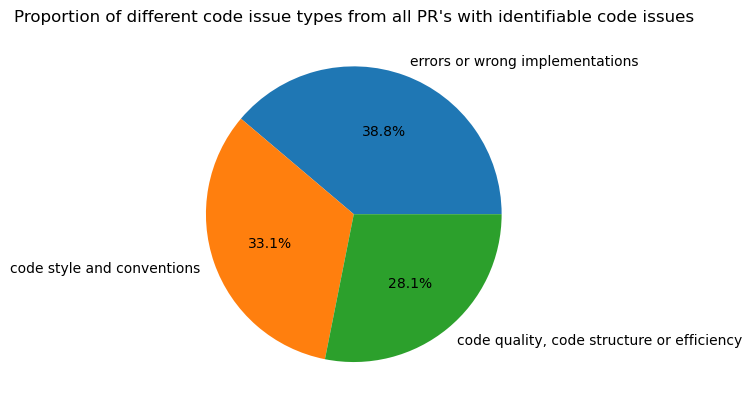

In [15]:
import matplotlib.pyplot as plt

labels = "errors or wrong implementations", "code style and conventions", "code quality, code structure or efficiency"
sizes = [issue_counts["errors or wrong implementations"], issue_counts["code style and conventions"], issue_counts["code quality, code structure or efficiency"]]

plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title("Proportion of different code issue types from all PR's with identifiable code issues")
plt.show()